## Building a CNN
Code implemeted from [link](https://colab.research.google.com/github/pytorch/ignite/blob/master/examples/notebooks/FashionMNIST.ipynb#scrollTo=lW6m6Stp6pty) 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [2]:
# Normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
train_set = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# Download and load the test data
val_set = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(val_set, batch_size = 64, shuffle=True)

## Making a model of our CNN class


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(64*6*6, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

## Creating Model, Optimizer and Loss

In [4]:
# create the model
model = CNN()

# moving model to gpu
device = torch.device("cpu")
print(f'Using device: {device}')
model.to(device)

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr = 0.001) # Adam optimizer
criterion = nn.NLLLoss() # negative log likelihood loss

Using device: cpu


## Training a network and Testing it on test dataset

In [5]:
# define the number of epochs
epochs = 15

# create trainer, evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device = device)
metrics = {
    'accuracy': Accuracy(),
    'nll': Loss(criterion),
    'cm': ConfusionMatrix(num_classes=10)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy':[], 'loss':[]}
validation_history = {'accuracy':[], 'loss':[]}
last_epoch = []

### Metrics - RunningAverage

In [6]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

### EarlyStopping - Tracking Validation Loss

In [7]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

### Attaching Custom Functions to Engine at Specific Events

In [8]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {} | Avg accuracy: {:.3f} | Avg loss: {:.3f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']
    loss = metrics['nll']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {} | Avg accuracy: {:.3f} | Avg loss: {:.3f}"
            .format(trainer.state.epoch, accuracy, loss))

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

## Confusion Matrix

In [9]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']/10 # confusion matrix
    cm = cm.numpy()
    cm = cm.astype(int)

    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

    fig, ax = plt.subplots(figsize = (10,10))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'd')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix for each of the 10 classes')
    ax.xaxis.set_ticklabels(classes, rotation=90)
    ax.yaxis.set_ticklabels(classes, rotation=0)

### Model Checkpoint

In [10]:
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})

### Run engine

/Users/uu/opt/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Training Results - Epoch: 1 | Avg accuracy: 0.889 | Avg loss: 0.305
Validation Results - Epoch: 1 | Avg accuracy: 0.876 | Avg loss: 0.346
Training Results - Epoch: 2 | Avg accuracy: 0.911 | Avg loss: 0.245
Validation Results - Epoch: 2 | Avg accuracy: 0.897 | Avg loss: 0.297
Training Results - Epoch: 3 | Avg accuracy: 0.895 | Avg loss: 0.286
Validation Results - Epoch: 3 | Avg accuracy: 0.878 | Avg loss: 0.343
Training Results - Epoch: 4 | Avg accuracy: 0.931 | Avg loss: 0.192
Validation Results - Epoch: 4 | Avg accuracy: 0.909 | Avg loss: 0.263
Training Results - Epoch: 5 | Avg accuracy: 0.941 | Avg loss: 0.165
Validation Results - Epoch: 5 | Avg accuracy: 0.911 | Avg loss: 0.255
Training Results - Epoch: 6 | Avg accuracy: 0.935 | Avg loss: 0.175
Validation Results - Epoch: 6 | Avg accuracy: 0.905 | Avg loss: 0.273
Training Results - Epoch: 7 | Avg accuracy: 0.945 | Avg loss: 0.153
Validation Results - Epoch: 7 | Avg accuracy: 0.911 | Avg loss: 0.267
Training Results - Epoch: 8 | Avg 

2022-11-15 22:18:33,388 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch: 15 | Avg accuracy: 0.909 | Avg loss: 0.323


2022-11-15 22:18:35,314 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 14070
	epoch: 15
	epoch_length: 938
	max_epochs: 15
	output: 0.028440773487091064
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

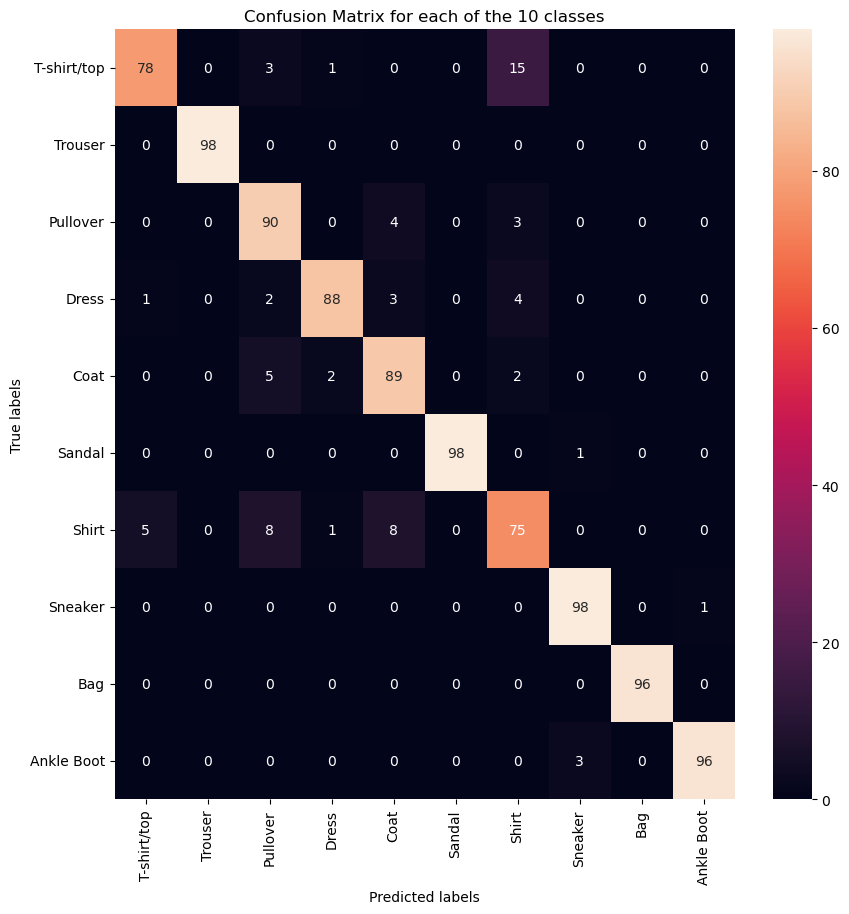

In [11]:
trainer.run(train_loader, max_epochs=epochs)

### Plotting the loss and accuracy

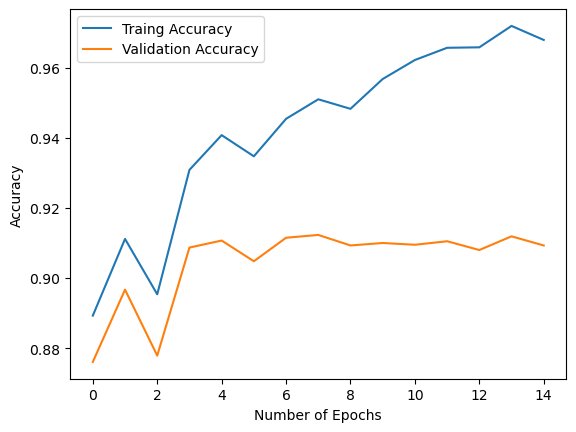

In [12]:
plt.plot(training_history['accuracy'], label='Traing Accuracy')
plt.plot(validation_history['accuracy'], label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon = True)
plt.show()

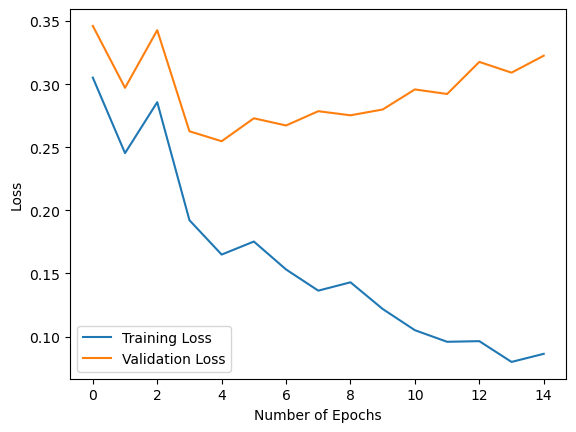

In [13]:
plt.plot(training_history['loss'], label='Training Loss')
plt.plot(validation_history['loss'], label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=True)
plt.show()

### Loading the saved model from the disk for inferencing

In [14]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    from pathlib import Path
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [ 
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return Path(model_save_path) / checkpoint_files[last_idx]

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
print('Model Loaded')

Model Loaded


## Inferencing the model

In [15]:
# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# creating iterator for iterating the dataset
dataiter = iter(val_loader)
images, labels = dataiter.next()
images_arr = []
labels_arr = []
pred_arr = []
# moving model to cpu for inference 
model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,10):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze())
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'